# Run inference on test set and submit to Kaggle

In [22]:
import pandas as pd
import geopandas as gpd
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import clip

In [24]:
device = 'cpu'
num_labels = 49

## Get test IDs

In [3]:
test_ids = pd.read_csv('kaggle_data/test.csv')

metadata_cols = ['gridimage_id', 'title', 'grid_reference']
metadata = pd.concat([
    pd.read_csv('kaggle_data/metadata.csv', on_bad_lines='skip', usecols=metadata_cols),
    pd.read_csv('kaggle_data/metadata-extra.csv', on_bad_lines='skip', encoding='latin1', usecols=metadata_cols)
])

test_id2title = (
    metadata
    .merge(test_ids, on='gridimage_id', how='inner')
    .assign(
        gridimage_id=lambda df_: df_.gridimage_id.astype(int),
        title=lambda df_: df_.title.fillna('')
    )
    .set_index('gridimage_id')
    .title.to_dict()
)

In [4]:
# Get tags in the right order
tags = pd.read_csv('kaggle_data/train.csv', nrows=0).columns[1:]
tag2human = pd.read_csv( 'kaggle_data/tags-top.csv', index_col='col')['tag'].to_dict()
tags_human = [ tag2human[tag] for tag in tags ]

## Once again, set up the location embedder (same as training)

In [36]:
grid2coords = (
    gpd.read_file(
        'misc/os_bng_grids.gpkg',
        layer='1km_grid'
    ).rename(
        columns={'tile_name': 'grid_reference'}
    )
    .to_crs(4326)
    .assign(
        geom_=lambda gdf_: gdf_.geometry.centroid,
        lat=lambda gdf_: gdf_.geom_.y,
        lon=lambda gdf_: gdf_.geom_.x
    )
    .set_index('grid_reference')
    [['lat', 'lon']].to_dict(orient='index')
)

img2grid = metadata.set_index('gridimage_id').grid_reference.to_dict()


# UK bounds to rescale
uk = {
    'lat': {'min': 49.9, 'max': 61.9},
    'lon': {'min': -8.6, 'max': 2.1}
}

def get_loc_emb(img_id):
    """Get rescaled lat/lon values"""
    try:
        coords_dict = grid2coords[img2grid[img_id]]
        lat, lon = coords_dict['lat'], coords_dict['lon']

        lat_norm = (lat - uk['lat']['min']) / (uk['lat']['max'] - uk['lat']['min'])
        lon_norm = (lon - uk['lon']['min']) / (uk['lon']['max'] - uk['lon']['min'])
    
        return torch.tensor([lat_norm, lon_norm], dtype=torch.float32)
    except:
        return torch.tensor([0, 0], dtype=torch.float32)

def add_location(batch):
    # img_id, img_f, txt_f, loc_f, y
    # batch is a list of items from full_ds[idx], e.g.
    #   [(img_id0, img_f0, txt_f0, label0), (img_id1, img_f1, txt_f1, label1), …]
    
    img_ids, img_fs, txt_fs, loc_fs = [], [], [], []
    
    for img_id, img_f, txt_f in batch:
        img_ids.append(img_id)
        img_fs.append(img_f)
        txt_fs.append(txt_f)
        loc_fs.append(get_loc_emb(img_id))

    return (
        torch.stack(img_ids),
        torch.stack(img_fs),
        torch.stack(txt_fs),
        torch.stack(loc_fs)
    )

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_34364/2641091950.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geom_=lambda gdf_: gdf_.geometry.centroid,


## Load test embeddings

In [37]:
test_ds = torch.load('splits/test_dataset.pt', weights_only=False)

In [38]:
test_dl = DataLoader(
    test_ds,
    batch_size=4096, shuffle=False,  num_workers=0,
    collate_fn=add_location # Add location embeddings
)

# Test all heads

In [39]:
head_names = [x for x in os.listdir('./heads') if x.endswith('.pth')]
head_names

['linear-img-mixup.pth',
 'linear-txt-loc.pth',
 'mlp-img-loc.pth',
 'mlp-img-txt-loc-mixup.pth',
 'linear-txt-mixup.pth',
 'linear-img-txt-mixup.pth',
 'mlp-txt.pth',
 'linear-img-txt-loc.pth',
 'mlp-txt-loc.pth',
 'mlp-img-txt-mixup.pth',
 'mlp-img.pth',
 'mlp-img-mixup.pth',
 'linear-img-loc.pth',
 'mlp-img-txt-loc.pth',
 'mlp-txt-mixup.pth',
 'mlp-txt-loc-mixup.pth',
 'linear-txt-loc-mixup.pth',
 'mlp-img-loc-mixup.pth',
 'linear-img-txt-loc-mixup.pth',
 'mlp-img-txt.pth',
 'linear-img-loc-mixup.pth',
 'linear-img.pth',
 'linear-img-txt.pth',
 'linear-txt.pth']

In [56]:
%%time

for head_name in head_names:

    use_img = 'img' in head_name
    use_txt = 'txt' in head_name
    use_loc = 'loc' in head_name

    # Calculate classifier input dimension
    input_dim = sum([
        512 if use_img else 0,
        512 if use_txt else 0,
        2 if use_loc else 0
    ])

    # Set up head architecture
    if head_name.split('-')[0] == 'mlp':
        head = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_labels)
        ).to(device)
    elif head_name.split('-')[0] == 'linear':
        head = nn.Linear(input_dim, num_labels).to(device)
    else:
        print(f'Cannot build {head_name}.')

    # Load model params
    head.load_state_dict(
        torch.load(
            f'heads/{head_name}',
            map_location=device
        )
    )

    head.eval()
    all_probs = []
    all_ids = []
    
    with torch.no_grad():
        for img_id, img_f, txt_f, loc_f in test_dl:
            fused_parts = []
            if use_img:
                fused_parts.append(img_f)
            if use_txt:
                fused_parts.append(txt_f)
            if use_loc:
                fused_parts.append(loc_f)
    
            fused = torch.cat(fused_parts, dim=1).to(device)
    
            probs = torch.sigmoid(head(fused))
            all_probs.append(probs.cpu())
            all_ids.extend(img_id)

    all_probs = torch.cat(all_probs)  # shape: [N, num_labels]
    preds = (all_probs > 0.5).int() # binarise predictions

    # Ensure that we have at least 1 positive tag!
    no_positive = preds.sum(dim=1) == 0
    max_indices = all_probs.argmax(dim=1)
    preds[no_positive, :] = 0
    preds[no_positive, max_indices[no_positive]] = 1

    submission = pd.DataFrame(
        index=[int(x) for x in all_ids],
        data=preds,
        columns=tags
    )
    submission.index.name = 'gridimage_id'

    submission.to_csv(f'submissions/{head_name.replace(".pth", ".csv.zip")}')

CPU times: user 3min 18s, sys: 57.3 s, total: 4min 16s
Wall time: 41.7 s


<Axes: >

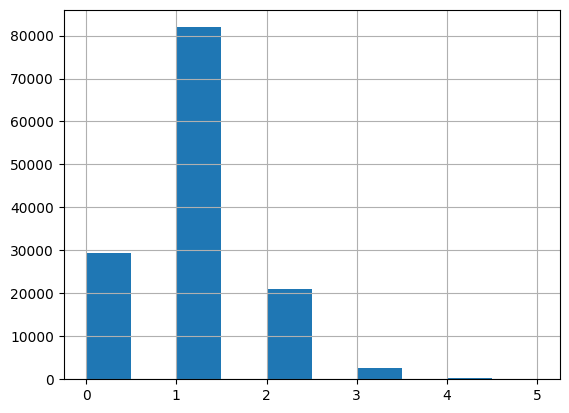

In [55]:
submission.sum(axis=1).hist()